# Bot classifier

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.externals import joblib
from sklearn import model_selection, linear_model
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style="white", color_codes=True)
sns.set_context(rc={"font.family":'sans',"font.size":24,"axes.titlesize":24,"axes.labelsize":24})   

import missingno as msno

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
full = pd.read_csv('data/full/train.csv')

In [3]:
full.columns

Index(['avg_fav', 'avg_hash', 'avg_len', 'avg_ret', 'contributors_enabled',
       'created_at', 'default_profile', 'default_profile_image', 'description',
       'fake_words_score', 'favourites_count', 'follow_request_sent',
       'followers_count', 'following', 'freq', 'friends_count',
       'genuine_words_score', 'geo_enabled', 'is_translator', 'lang',
       'listed_count', 'location', 'max_fav', 'max_hash', 'max_len', 'max_ret',
       'media_perc', 'min_fav', 'min_hash', 'min_len', 'min_ret', 'name',
       'notifications', 'porn_words_score', 'profile_background_color',
       'profile_background_image_url', 'profile_background_image_url_https',
       'profile_background_tile', 'profile_image_url',
       'profile_image_url_https', 'profile_link_color',
       'profile_sidebar_border_color', 'profile_sidebar_fill_color',
       'profile_text_color', 'profile_use_background_image',
       'prop_words_score', 'protected', 'quote_perc', 'ret_perc',
       'screen_name', 'spam_wo

## Data exploration

In [4]:
full.describe()

,avg_fav,avg_hash,avg_len,avg_ret,contributors_enabled,default_profile,default_profile_image,fake_words_score,favourites_count,follow_request_sent,...,ret_perc,spam_words_score,statuses_count,target,tweet_intradistance,url_intradistance,url_perc,user_id,utc_offset,verified
count,25640.000000,25640.000000,25640.000000,25640.000000,18815.0,22881.000000,18834.000000,25640.000000,25640.000000,18815.0,...,25640.000000,25640.000000,2.564000e+04,25640.000000,25640.000000,25640.000000,25640.000000,2.564000e+04,2810.000000,18826.000000
mean,6.610835,0.190830,58.422766,1511.855264,0.0,0.709584,0.053308,0.023964,5888.202340,0.0,...,0.246851,0.031035,1.115940e+04,1.859360,7.599940,1.968377,0.132881,1.782175e+17,-4889.145907,0.004621
std,457.934517,0.488714,52.522072,5398.952052,0.0,0.453964,0.224653,0.063482,26113.194008,0.0,...,0.360419,0.049565,4.167535e+04,1.418054,6.093964,2.621330,0.232582,3.676792e+17,22037.451204,0.067824
min,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,6.780330e+05,-39600.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,2.100000e+01,0.000000,0.000000,0.000000,0.000000,4.099121e+08,-25200.000000,0.000000
50%,0.000000,0.040404,66.970000,0.047059,0.0,1.000000,0.000000,0.013552,80.500000,0.0,...,0.000000,0.015500,9.100000e+01,2.000000,10.738526,0.000000,0.000000,1.434536e+09,-14400.000000,0.000000
75%,0.090909,0.206615,93.282591,778.775000,0.0,1.000000,0.000000,0.026403,492.000000,0.0,...,0.512821,0.043259,3.253250e+03,3.000000,12.236601,3.526084,0.170000,2.927803e+09,13500.000000,0.000000
max,71540.120000,17.000000,373.390000,247147.066667,0.0,1.000000,1.000000,1.855191,913239.000000,0.0,...,1.000000,0.898990,1.418488e+06,4.000000,27.574898,10.090432,1.000000,1.036369e+18,46800.000000,1.000000


Delete naive features 

In [5]:
full = full.drop(columns=['contributors_enabled', 'follow_request_sent', 'following', 'profile_background_image_url', 'profile_background_image_url_https', 'profile_image_url', 'profile_image_url_https', 'time_zone', 'utc_offset'])

plot missing values

In [6]:
features = full.columns

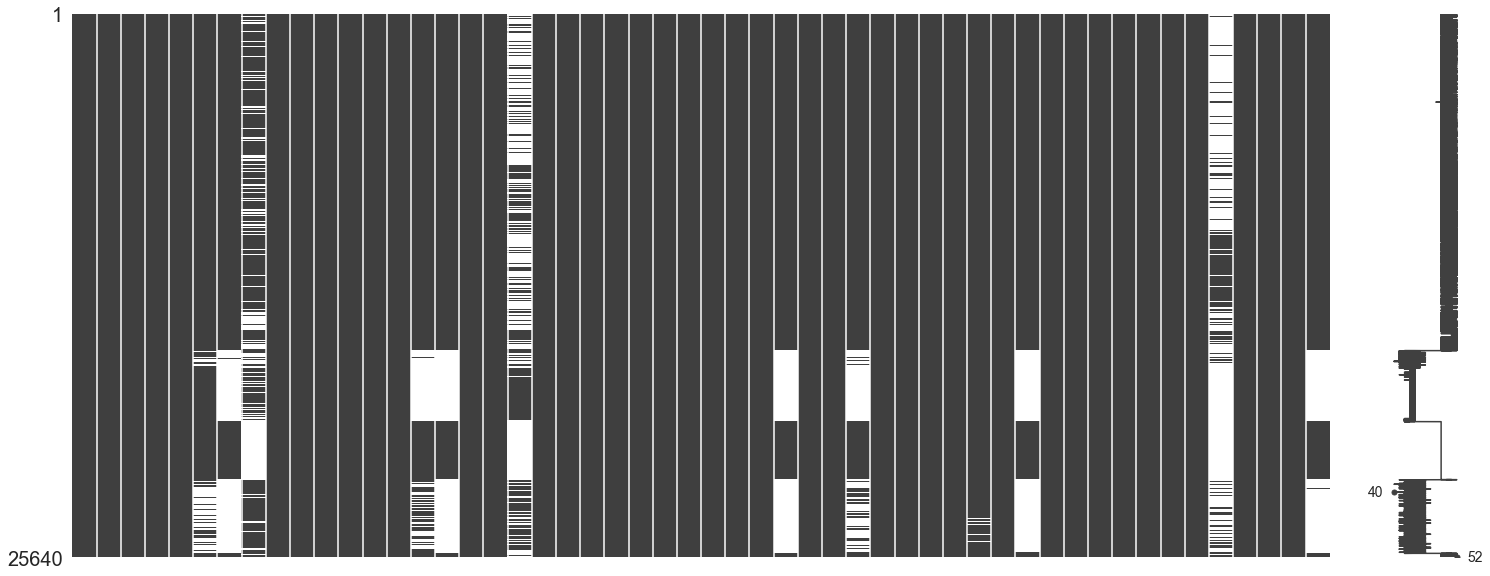

In [7]:
msno.matrix(full)

plot missing values for each target

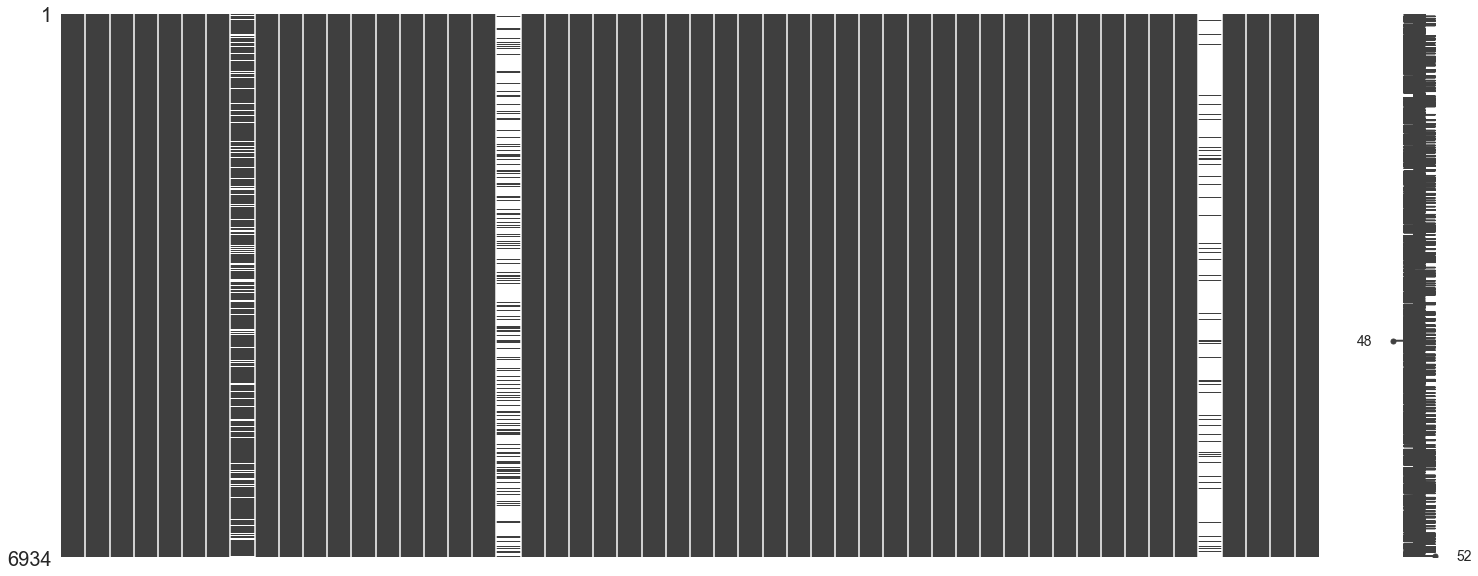

In [8]:
msno.matrix(full[full.target==0])

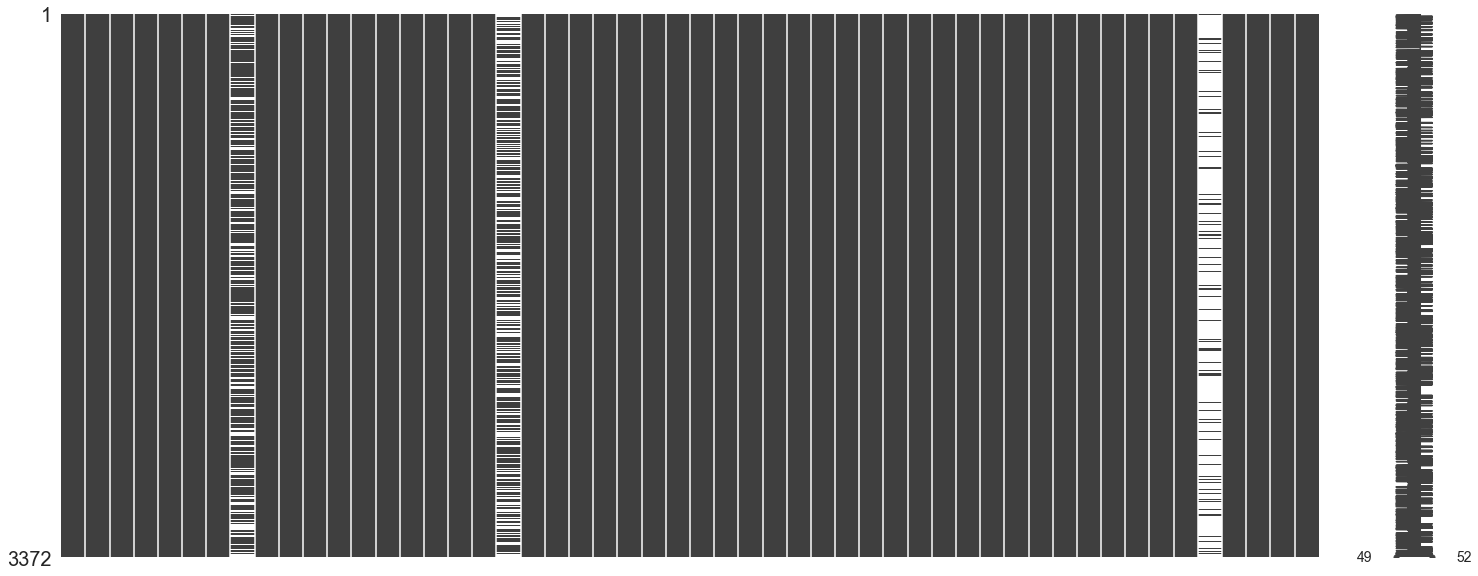

In [9]:
msno.matrix(full[full.target==1])

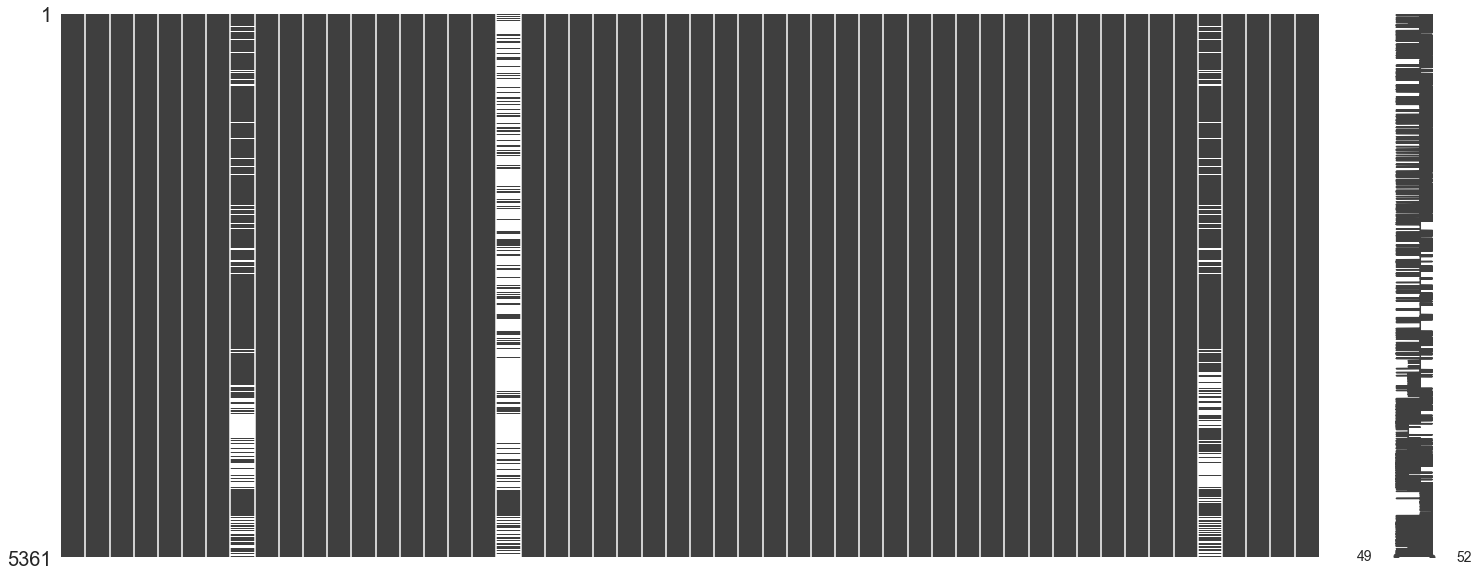

In [10]:
msno.matrix(full[full.target==2])

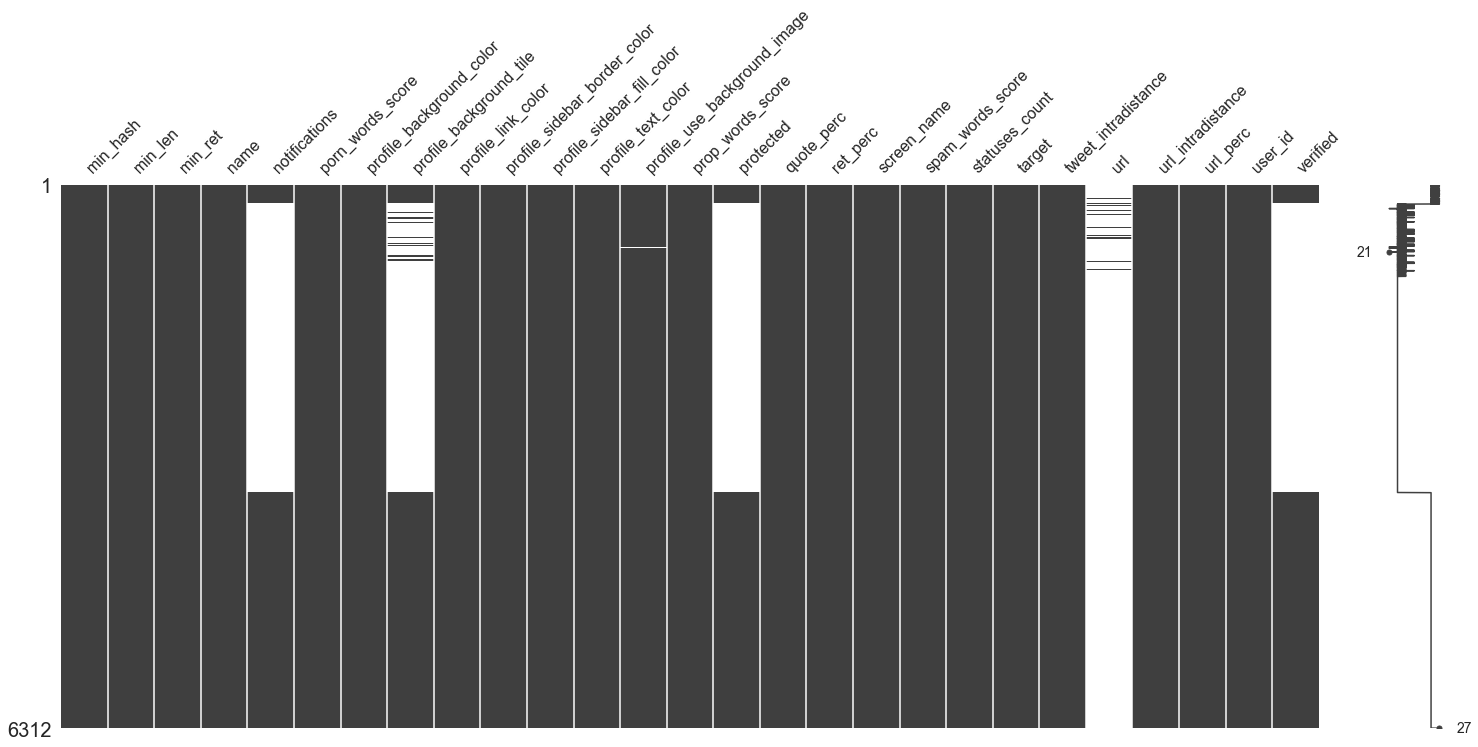

In [11]:
msno.matrix(full[full.target==3][features[25:]])

In [19]:
full[full.target==4]['verified'].value_counts()

0.0    182
1.0     16
Name: verified, dtype: int64

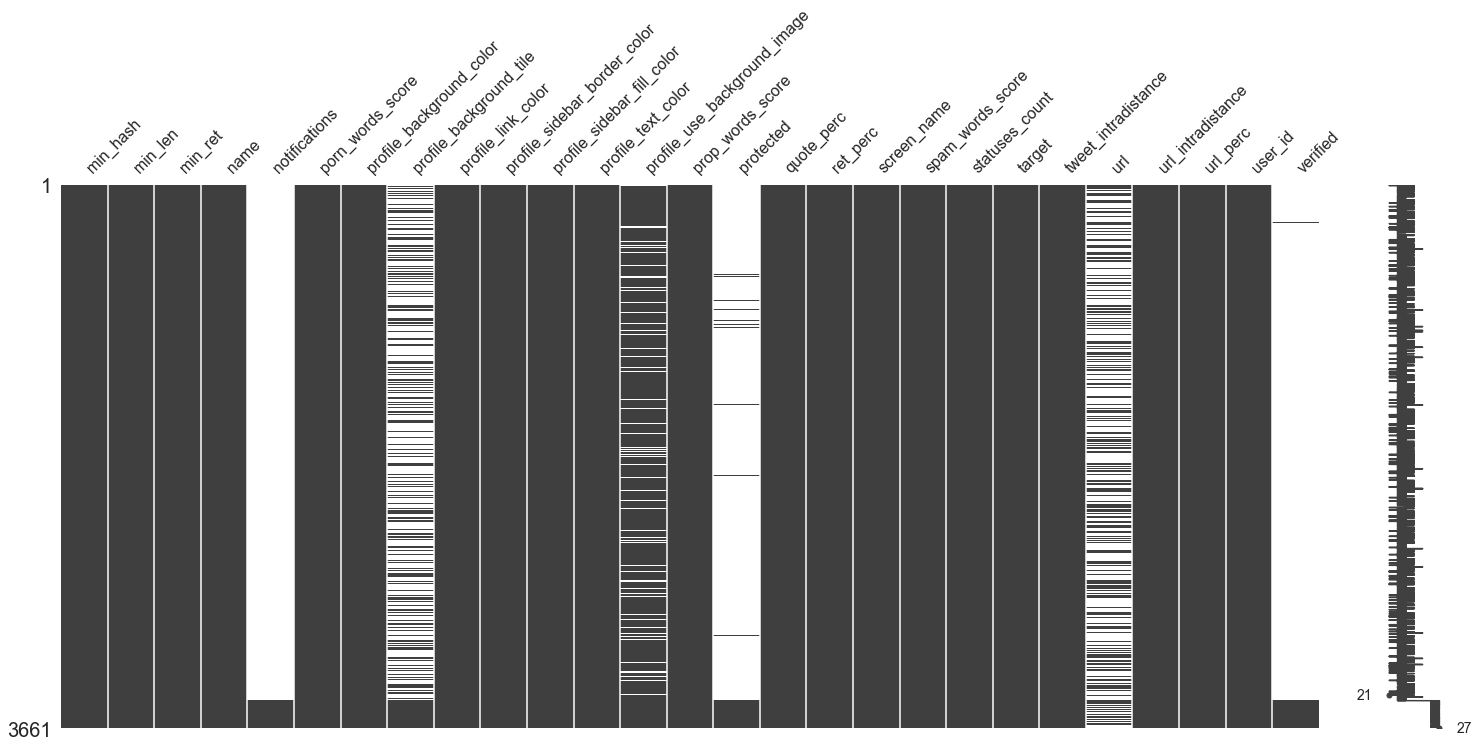

In [12]:
msno.matrix(full[full.target==4][features[25:]])

Remove features with too many missing values for some target

In [15]:
full = full.drop(columns=['default_profile_image','is_translator', 'geo_enabled', 'location', 'notifications', 'profile_background_tile', 'protected', 'verified'])

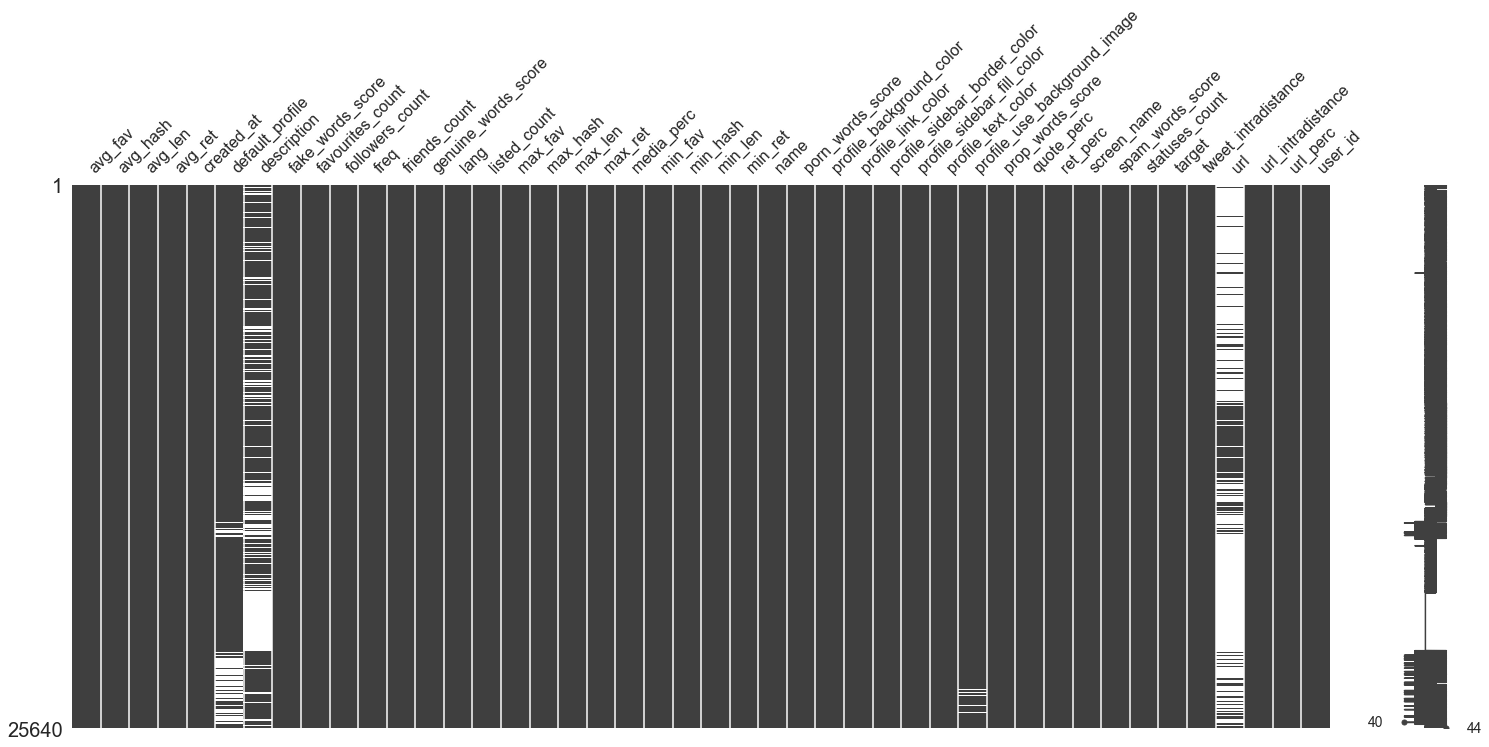

In [16]:
msno.matrix(full)

In [20]:
full.default_profile.describe()

count    22881.000000
mean         0.709584
std          0.453964
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: default_profile, dtype: float64

In [21]:
full[full.target==3].default_profile.describe()

count    5995.000000
mean        0.993328
std         0.081418
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: default_profile, dtype: float64

In [22]:
full[full.target==4].default_profile.describe()

count    1219.000000
mean        0.922888
std         0.266879
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: default_profile, dtype: float64

In [23]:
full['default_profile'] = full['default_profile'].fillna(full['default_profile'].mode()[0])

In [24]:
full['description'] = full['description'].fillna('')

In [25]:
full['description_len'] = full['description'].apply(lambda x: len(x))

In [26]:
full = full.drop(columns=['description'])

In [27]:
full['name'] = full['name'].fillna('')

In [28]:
full['name_len'] = full['name'].apply(lambda x: len(x))

In [29]:
full = full.drop(columns=['name'])

In [30]:
full['screen_name'] = full['screen_name'].fillna('')

In [31]:
full['screen_name_len'] = full['screen_name'].apply(lambda x: len(x))

In [32]:
full = full.drop(columns=['screen_name'])

In [33]:
full = full.drop(columns=['lang'])

In [34]:
def oldness(x):
    if x[0] == '2':
        return 2018 - int(x[:4])
    else:
        return 2018 - int(x[-4:])

In [35]:
full['oldness'] = full['created_at'].apply(lambda x: oldness(x))

In [36]:
full = full.drop(columns=['created_at'])

In [37]:
full = full.drop(columns=['user_id'])

In [38]:
full['profile_use_background_image'][full.target==4].value_counts()

1.0    3246
0.0      25
Name: profile_use_background_image, dtype: int64

In [39]:
full['profile_use_background_image'] = full['profile_use_background_image'].fillna(full['profile_use_background_image'].mode()[0])

In [40]:
full['url'] = (full['url'].notnull()).astype(int)

verifico che non ci siano più missing values

In [41]:
full.isnull().astype(int).sum()

avg_fav                         0
avg_hash                        0
avg_len                         0
avg_ret                         0
default_profile                 0
fake_words_score                0
favourites_count                0
followers_count                 0
freq                            0
friends_count                   0
genuine_words_score             0
listed_count                    0
max_fav                         0
max_hash                        0
max_len                         0
max_ret                         0
media_perc                      0
min_fav                         0
min_hash                        0
min_len                         0
min_ret                         0
porn_words_score                0
profile_background_color        0
profile_link_color              0
profile_sidebar_border_color    0
profile_sidebar_fill_color      0
profile_text_color              0
profile_use_background_image    0
prop_words_score                0
quote_perc    

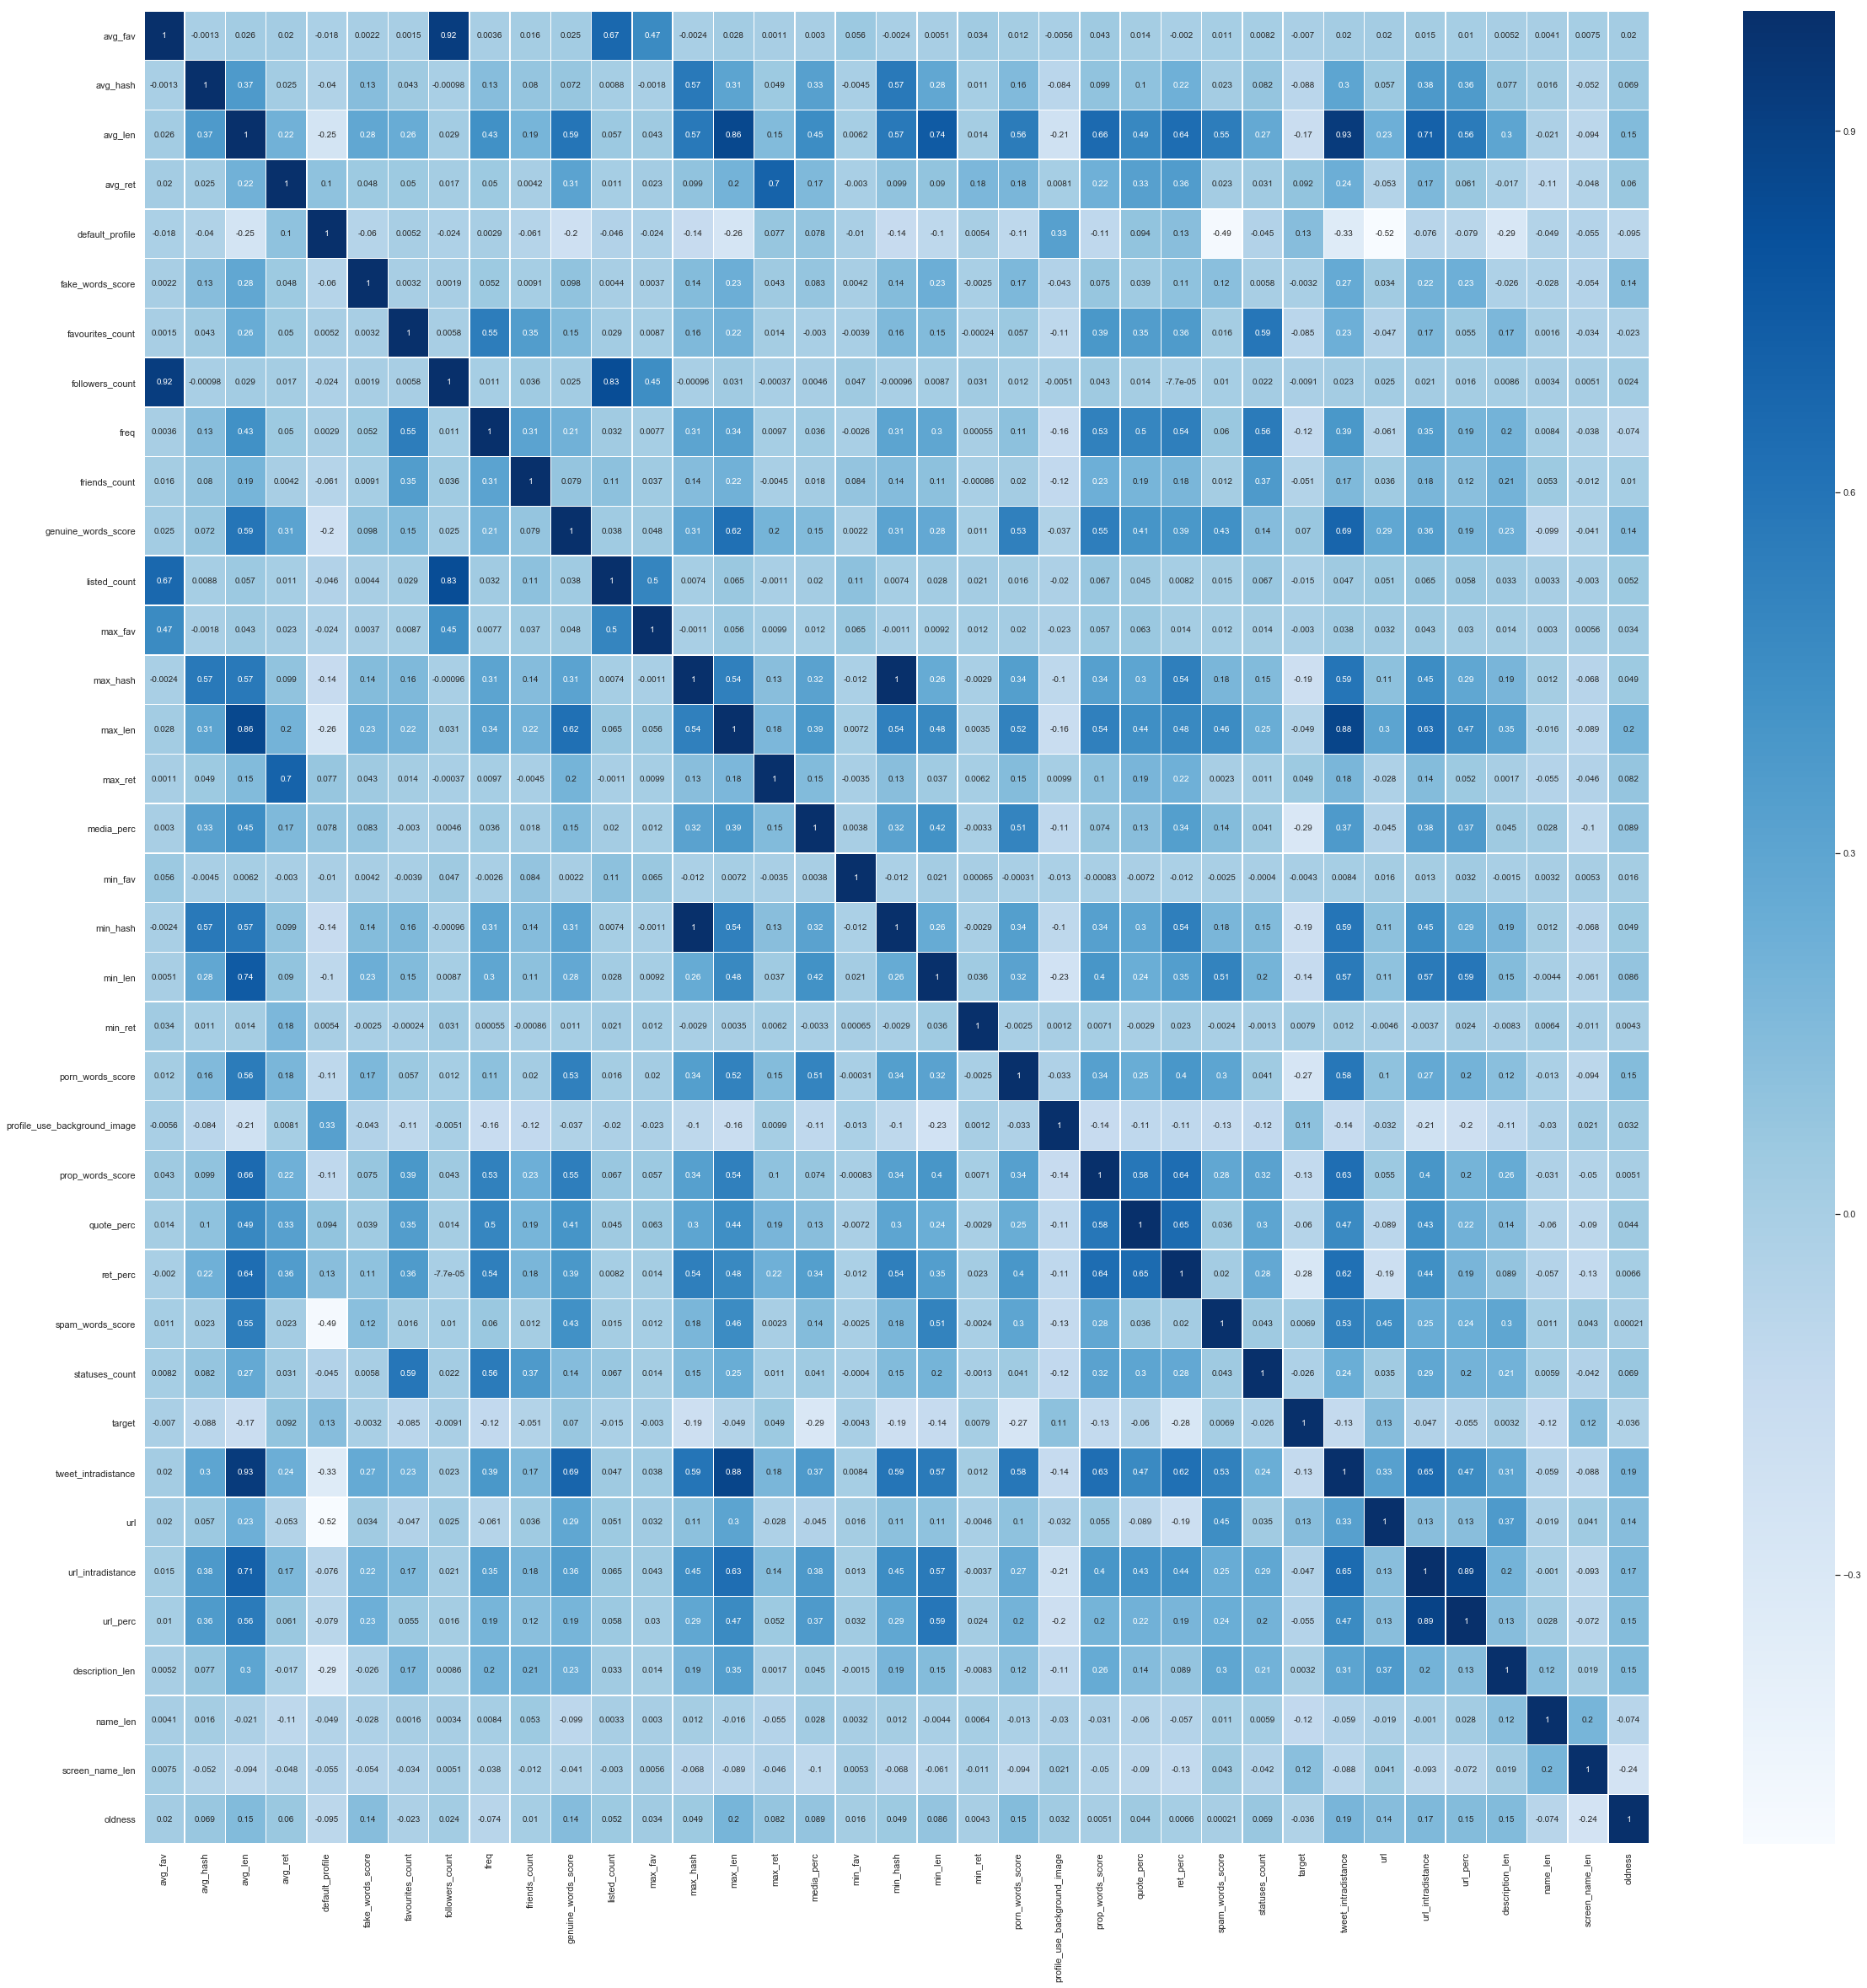

In [42]:
fig, ax = plt.subplots(figsize=(40,40))
cov=full.corr(method='pearson')
sns.heatmap(cov,annot=True,cmap="Blues",linewidths=.5, ax=ax)

In [43]:
cov['target'].sort_values(ascending=False)

target                          1.000000
url                             0.134524
default_profile                 0.133037
screen_name_len                 0.123419
profile_use_background_image    0.109704
avg_ret                         0.091578
genuine_words_score             0.069993
max_ret                         0.049168
min_ret                         0.007863
spam_words_score                0.006912
description_len                 0.003189
max_fav                        -0.003014
fake_words_score               -0.003221
min_fav                        -0.004273
avg_fav                        -0.007011
followers_count                -0.009137
listed_count                   -0.015029
statuses_count                 -0.025547
oldness                        -0.036271
url_intradistance              -0.047305
max_len                        -0.049183
friends_count                  -0.050804
url_perc                       -0.054661
quote_perc                     -0.059960
favourites_count

In [44]:
full.columns

Index(['avg_fav', 'avg_hash', 'avg_len', 'avg_ret', 'default_profile',
       'fake_words_score', 'favourites_count', 'followers_count', 'freq',
       'friends_count', 'genuine_words_score', 'listed_count', 'max_fav',
       'max_hash', 'max_len', 'max_ret', 'media_perc', 'min_fav', 'min_hash',
       'min_len', 'min_ret', 'porn_words_score', 'profile_background_color',
       'profile_link_color', 'profile_sidebar_border_color',
       'profile_sidebar_fill_color', 'profile_text_color',
       'profile_use_background_image', 'prop_words_score', 'quote_perc',
       'ret_perc', 'spam_words_score', 'statuses_count', 'target',
       'tweet_intradistance', 'url', 'url_intradistance', 'url_perc',
       'description_len', 'name_len', 'screen_name_len', 'oldness'],
      dtype='object')

In [85]:
def predict(X, y, n_trees=5, max_depth=None, knn=10):
    
    forest = RandomForestClassifier(n_estimators = n_trees, max_depth=max_depth, criterion = 'entropy', random_state = 42)
    logreg = linear_model.LogisticRegression()
    
    scaler = MinMaxScaler()
    X_n = scaler.fit_transform(X)
    knn = KNeighborsClassifier(n_neighbors=knn)
    scoring = ['f1_macro', 'precision_macro', 'recall_macro']
    scores = []
    scores.append(cross_validate(forest, X, y, cv=10, scoring=scoring))
    scores.append(cross_validate(logreg, X, y, cv=10, scoring=scoring))
    scores.append(cross_validate(knn, X_n, y, cv=10, scoring=scoring))
    
    return scores

In [47]:
# only our descriptive features
X = full[['avg_fav', 'avg_hash', 'avg_len', 'avg_ret',
       'freq', 'max_fav', 'max_hash', 'max_len', 'max_ret', 'media_perc', 'min_fav', 'min_hash',
       'min_len', 'min_ret', 'quote_perc',
       'ret_perc', 'url_perc', 'description_len', 'name_len', 'screen_name_len', 'oldness']]
y = full['target']

In [53]:
predict(X,y)

[0.8277602952231404, 0.6204151612167635, 0.7883799109996785]

In [54]:
forest.fit(X,y)
sorted(zip(map(lambda x: round(x, 4), forest.feature_importances_), X.columns), reverse=True)

NameError: name 'forest' is not defined

In [123]:
# only context features
X = full[['fake_words_score', 'genuine_words_score', 'porn_words_score', 'prop_words_score', 'spam_words_score']]
y = full['target']

In [124]:
predict(X,y)

[0.6932601922431718, 0.6494730683760064, 0.5849899970979726]

In [125]:
forest.fit(X,y)
sorted(zip(map(lambda x: round(x, 4), forest.feature_importances_), X.columns), reverse=True)

[(0.2395, 'spam_words_score'),
 (0.2373, 'porn_words_score'),
 (0.2056, 'prop_words_score'),
 (0.1609, 'fake_words_score'),
 (0.1567, 'genuine_words_score')]

In [55]:
# only intradistance features
X = full[['tweet_intradistance', 'url_intradistance']]
y = full['target']

In [57]:
predict(X,y, n_trees=10, max_depth=None, knn=15)

[0.596831360940375, 0.47008551184818137, 0.4491419372936297]

In [128]:
forest.fit(X,y)
sorted(zip(map(lambda x: round(x, 4), forest.feature_importances_), X.columns), reverse=True)

[(0.6093, 'tweet_intradistance'), (0.3907, 'url_intradistance')]

In [58]:
# context + intradistance
X = full[['fake_words_score', 'genuine_words_score', 'porn_words_score', 'prop_words_score', 'spam_words_score', 'tweet_intradistance', 'url_intradistance']]
y = full['target']

In [59]:
predict(X,y, n_trees=5, max_depth=None, knn=10)

[0.7093882608083582, 0.6629541867573072, 0.5885390523694245]

In [60]:
predict(X,y, n_trees=10, max_depth=None, knn=7)

[0.7172839043295939, 0.6629541867573072, 0.5905155923498773]

In [131]:
forest.fit(X,y)
sorted(zip(map(lambda x: round(x, 4), forest.feature_importances_), X.columns), reverse=True)

[(0.2109, 'spam_words_score'),
 (0.2006, 'tweet_intradistance'),
 (0.1488, 'porn_words_score'),
 (0.1355, 'genuine_words_score'),
 (0.1084, 'url_intradistance'),
 (0.104, 'prop_words_score'),
 (0.0918, 'fake_words_score')]

In [61]:
# our features 
X = full[['avg_fav', 'avg_hash', 'avg_len', 'avg_ret',
       'fake_words_score', 'freq',
       'genuine_words_score', 'max_fav',
       'max_hash', 'max_len', 'max_ret', 'media_perc', 'min_fav', 'min_hash',
       'min_len', 'min_ret', 'porn_words_score',
       'prop_words_score', 'quote_perc',
       'ret_perc', 'spam_words_score',
       'tweet_intradistance', 'url', 'url_intradistance', 'url_perc',
       'description_len', 'name_len', 'screen_name_len', 'oldness']]
y = full['target']

In [62]:
predict(X,y, n_trees=5, max_depth=None, knn=10)

[0.8329267941959106, 0.6242275076522097, 0.8044739660737296]

In [63]:
predict(X,y, n_trees=10, max_depth=None, knn=8)

[0.8459574487366561, 0.6242275076522097, 0.8086280239373321]

In [116]:
forest.fit(X,y)
sorted(zip(map(lambda x: round(x, 4), forest.feature_importances_), X.columns), reverse=True)

[(0.0945, 'oldness'),
 (0.0825, 'description_len'),
 (0.0687, 'tweet_intradistance'),
 (0.0645, 'ret_perc'),
 (0.061, 'spam_words_score'),
 (0.0577, 'media_perc'),
 (0.0571, 'max_len'),
 (0.0498, 'freq'),
 (0.0462, 'avg_len'),
 (0.0436, 'name_len'),
 (0.0408, 'prop_words_score'),
 (0.0355, 'genuine_words_score'),
 (0.0335, 'porn_words_score'),
 (0.0326, 'fake_words_score'),
 (0.0295, 'avg_ret'),
 (0.0273, 'url_perc'),
 (0.0248, 'url'),
 (0.0238, 'screen_name_len'),
 (0.0235, 'quote_perc'),
 (0.0208, 'min_len'),
 (0.0204, 'max_fav'),
 (0.016, 'max_ret'),
 (0.0152, 'avg_fav'),
 (0.012, 'avg_hash'),
 (0.0107, 'url_intradistance'),
 (0.0037, 'max_hash'),
 (0.0029, 'min_hash'),
 (0.0008, 'min_ret'),
 (0.0003, 'min_fav')]

In [64]:
# only default features
X = full[['default_profile', 'favourites_count', 'followers_count',
       'friends_count', 'listed_count', 'profile_use_background_image', 'statuses_count', 'url'
         ]]
y = full['target']

In [65]:
predict(X,y, n_trees=5, max_depth=None, knn=10)

[0.8679357989410065, 0.5021662998209949, 0.8220401073585675]

In [66]:
predict(X,y, n_trees=10, max_depth=None, knn=7)

[0.8767512808592951, 0.5021662998209949, 0.8180953337286615]

In [119]:
forest.fit(X,y)
sorted(zip(map(lambda x: round(x, 4), forest.feature_importances_), X.columns), reverse=True)

[(0.293, 'favourites_count'),
 (0.2318, 'statuses_count'),
 (0.1825, 'followers_count'),
 (0.1195, 'friends_count'),
 (0.0838, 'default_profile'),
 (0.0491, 'listed_count'),
 (0.0358, 'url'),
 (0.0044, 'profile_use_background_image')]

In [286]:
# all features except colors
X = full[['avg_fav', 'avg_hash', 'avg_len', 'avg_ret', 'default_profile',
       'fake_words_score', 'favourites_count', 'followers_count', 'freq',
       'friends_count', 'genuine_words_score', 'listed_count', 'max_fav',
       'max_hash', 'max_len', 'max_ret', 'media_perc', 'min_fav', 'min_hash',
       'min_len', 'min_ret', 'porn_words_score',
       'profile_use_background_image', 'prop_words_score', 'quote_perc',
       'ret_perc', 'spam_words_score', 'statuses_count',
       'tweet_intradistance', 'url', 'url_intradistance', 'url_perc',
       'description_len', 'name_len', 'screen_name_len', 'oldness']]

In [68]:
y = full['target']

In [69]:
predict(X,y, n_trees=5, max_depth=None, knn=10)

[0.9160726041569826, 0.6685918255013837, 0.8332611949453967]

In [86]:
scores = predict(X,y, n_trees=15, max_depth=None, knn=7)

## RF scores:

In [103]:
print("F1:")
print(scores[0]['test_f1_macro'].mean())
print("Precision:")
print(scores[0]['test_precision_macro'].mean())
print("Recall:")
print(scores[0]['test_recall_macro'].mean())

F1:
0.9315663413891941
Precision:
0.9357729205776583
Recall:
0.9338826001331455


## KNN scores:

In [106]:
print("F1:")
print(scores[2]['test_f1_macro'].mean())
print("Precision:")
print(scores[2]['test_precision_macro'].mean())
print("Recall:")
print(scores[2]['test_recall_macro'].mean())

F1:
0.8330622526894172
Precision:
0.8545184105516673
Recall:
0.8351033219038945


## Grid Search

In [131]:
def grid_search(X, y, model, params):
    
    scoring = ['f1_macro', 'precision_macro', 'recall_macro']
    grid = GridSearchCV(model, params, cv=10, scoring=scoring, refit='f1_macro')
    grid.fit(X, y)
    
    return grid

### KNN

In [121]:
params = {'n_neighbors':[5,7,10,15,20]}
model = knn = KNeighborsClassifier()
scaler = MinMaxScaler()
X_n = scaler.fit_transform(X)

knn_grid = grid_search(X_n, y, model, params)

In [126]:
import pandas as pd

In [130]:
knn_grid.best_params_

{'n_neighbors': 5}

In [135]:
knn_df = pd.DataFrame(knn_grid.cv_results_)

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_f1_macro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_f1_macro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_f1_macro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anac

In [137]:
knn_df.loc[1]

mean_fit_time                              0.54654
std_fit_time                                0.2335
mean_score_time                            3.86909
std_score_time                             1.05851
param_n_neighbors                                7
params                          {'n_neighbors': 7}
split0_test_f1_macro                      0.729459
split1_test_f1_macro                      0.816879
split2_test_f1_macro                      0.901592
split3_test_f1_macro                      0.890983
split4_test_f1_macro                      0.885432
split5_test_f1_macro                       0.89586
split6_test_f1_macro                      0.799091
split7_test_f1_macro                      0.861996
split8_test_f1_macro                      0.855926
split9_test_f1_macro                      0.693406
mean_test_f1_macro                        0.833045
std_test_f1_macro                        0.0691059
rank_test_f1_macro                               3
split0_train_f1_macro          

### Random Forest

In [170]:
params = {'n_estimators':[5,10,15,20,25,30,35,40,45,50], 'max_features':['auto'], 'criterion': ['gini', 'entropy']}
model = RandomForestClassifier()

rf_grid = grid_search(X, y, model, params)

In [171]:
rf_df = pd.DataFrame(rf_grid.cv_results_)

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_f1_macro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_f1_macro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_f1_macro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anac

In [172]:
rf_grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [173]:
results = rf_grid.cv_results_

In [192]:
results['param_criterion'][10:]

masked_array(data=['entropy', 'entropy', 'entropy', 'entropy', 'entropy',
                   'entropy', 'entropy', 'entropy', 'entropy', 'entropy'],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object)

In [215]:
results['mean_test_f1_macro'].max()

0.93517441669266

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


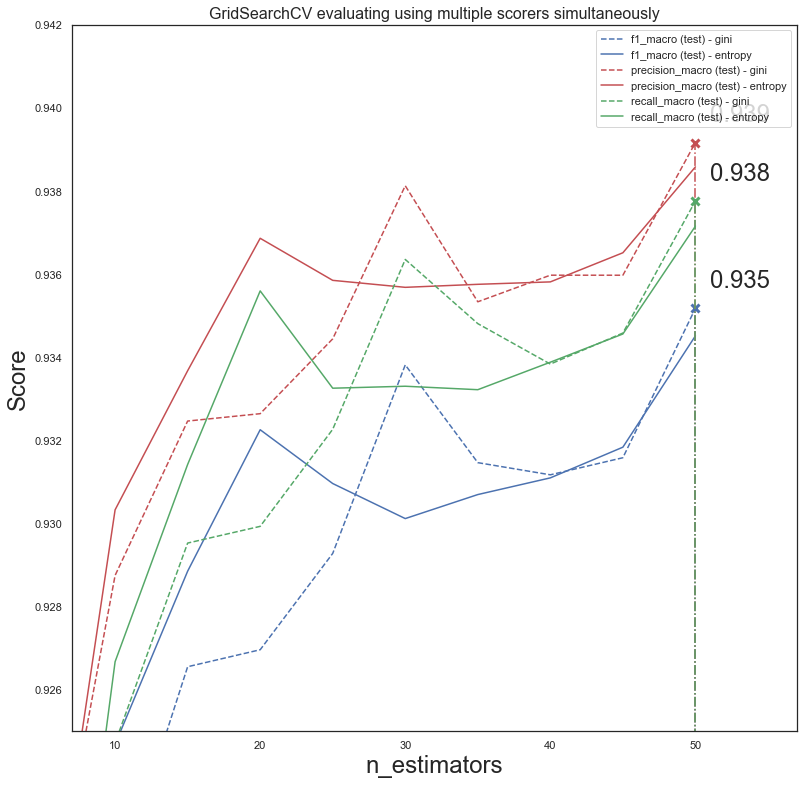

In [231]:
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("n_estimators")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
ax.set_xlim(7, 57)
ax.set_ylim(0.925, 0.942)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_n_estimators'].data, dtype=float)

scoring = ['f1_macro', 'precision_macro', 'recall_macro']

for score, color in zip(sorted(scoring), ['b', 'r', 'g']):
    sample_score_mean_gini = results['mean_%s_%s' % ('test', score)][:10]
    sample_score_mean_entropy = results['mean_%s_%s' % ('test', score)][10:]
    crit = results['param_criterion']
    ax.plot(X_axis[:10], sample_score_mean_gini, color=color,
            alpha=1 if sample == 'test' else 0.7,
            linestyle='--',
            label="%s (%s) - %s" % (score, sample, 'gini'))
    ax.plot(X_axis[10:], sample_score_mean_entropy, color=color,
            alpha=1 if sample == 'test' else 0.7,
            label="%s (%s) - %s" % (score, sample, 'entropy'))
 
    best_index = np.nonzero(results['rank_test_' + score] == 1)[0][0]
    best_score = results['mean_test_' + score].max()

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.3f" % best_score,
                (X_axis[best_index]+1, best_score + 0.0005))

plt.legend(loc="best")
plt.grid('off')
plt.show()

### Max depth tuning

In [285]:
X.columns

Index(['avg_fav', 'avg_hash', 'avg_len', 'avg_ret', 'default_profile',
       'fake_words_score', 'favourites_count', 'followers_count', 'freq',
       'friends_count', 'genuine_words_score', 'listed_count', 'max_fav',
       'max_hash', 'max_len', 'max_ret', 'media_perc', 'min_fav', 'min_hash',
       'min_len', 'min_ret', 'porn_words_score',
       'profile_use_background_image', 'prop_words_score', 'quote_perc',
       'ret_perc', 'spam_words_score', 'statuses_count', 'tweet_intradistance',
       'url', 'url_intradistance', 'url_perc', 'description_len', 'name_len',
       'screen_name_len', 'oldness'],
      dtype='object')

In [287]:
params = {'n_estimators':[30], 'max_depth':list(range(1,len(X.columns), 3)), 'criterion': ['gini']}
model = RandomForestClassifier()

rf_grid_depth = grid_search(X, y, model, params)

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Lorenzo/anaco

In [297]:
rf_drig_df = pd.DataFrame(rf_grid_depth.cv_results_)

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_f1_macro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_f1_macro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_f1_macro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anac

In [289]:
rf_grid_depth.best_params_

{'criterion': 'gini', 'max_depth': 22, 'n_estimators': 30}

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Series.data is deprecated and will be removed in a future version
  
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


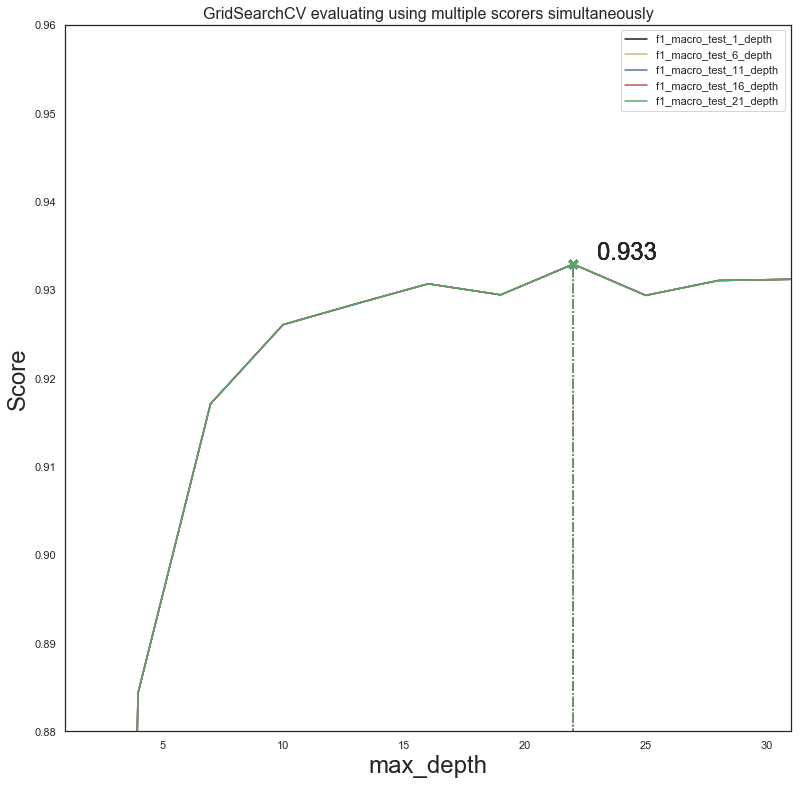

In [294]:
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("max_depth")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
ax.set_xlim(1, 31)
ax.set_ylim(0.88, 0.96)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(rf_drig_df['param_max_depth'].data, dtype=float)

depth = range(1,len(X.columns), 5)

for d, color in zip(depth, ['k', 'y', 'b', 'r', 'g']):
    sample_score = rf_drig_df['mean_test_f1_macro']
    ax.plot(X_axis, sample_score, color=color,
            alpha=1,
            linestyle='-',
            label="f1_macro_test_%s_depth " % d)
 
    best_index = np.nonzero(rf_drig_df['rank_test_f1_macro'] == 1)[0][0]
    best_score = rf_drig_df['mean_test_f1_macro'].max()

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.3f" % best_score,
                (X_axis[best_index]+1, best_score + 0.0005))

plt.legend(loc="best")
plt.grid('off')
plt.show()

In [295]:
params = {'n_estimators':[20,25,30,35,40], 'max_depth':list(range(15,30,3)), 'criterion': ['gini']}
model = RandomForestClassifier()

rf_grid_depth = grid_search(X, y, model, params)

In [296]:
rf_grid_depth.best_params_

{'criterion': 'gini', 'max_depth': 27, 'n_estimators': 40}

In [326]:
X_axis

array([20., 25., 30., 35., 40., 20., 25., 30., 35., 40., 20., 25., 30.,
       35., 40., 20., 25., 30., 35., 40., 20., 25., 30., 35., 40.])

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Series.data is deprecated and will be removed in a future version
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Series.data is deprecated and will be removed in a future version
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boole

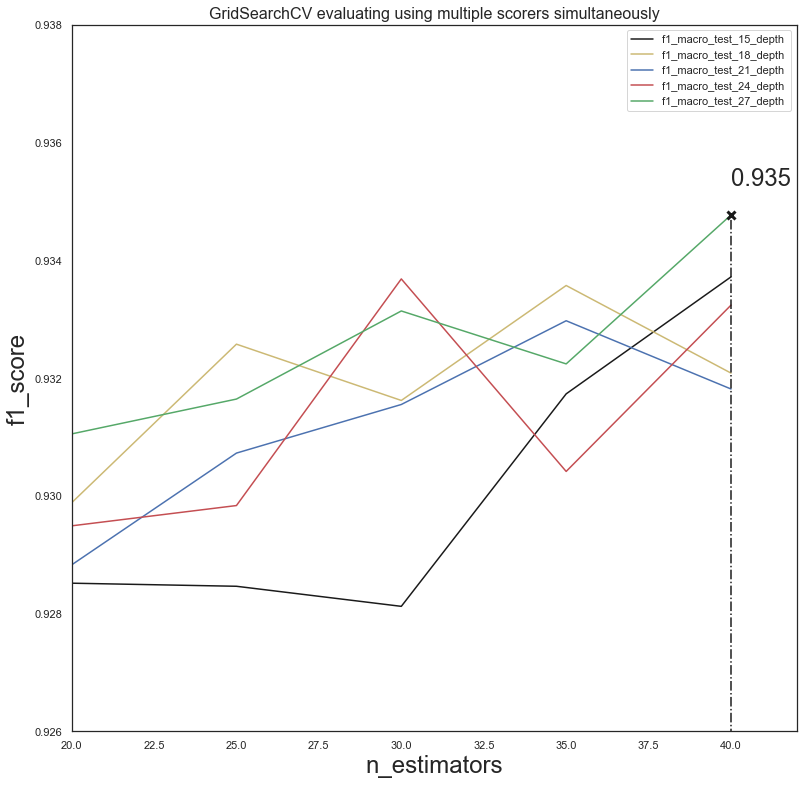

In [336]:
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("n_estimators")
plt.ylabel("f1_score")
plt.grid()

ax = plt.axes()
ax.set_xlim(20, 42)
ax.set_ylim(0.926, 0.938)

depth = range(15,30,3)

for d, color in zip(depth, ['k', 'y', 'b', 'r', 'g']):
    # Get the regular numpy array from the MaskedArray
    X_axis = np.array(rf_drig_df[rf_drig_df['param_max_depth'] == d]['param_n_estimators'].data, dtype=float)
    sample_score = rf_drig_df[rf_drig_df['param_max_depth'] == d]['mean_test_f1_macro']
    ax.plot(X_axis, sample_score, color=color,
            linestyle='-',
            label="f1_macro_test_%s_depth " % d)
    

best_index = np.nonzero(rf_drig_df['rank_test_f1_macro'] == 1)[0][0]
best_score = rf_drig_df['mean_test_f1_macro'].max()
X_axis = np.array(rf_drig_df['param_n_estimators'].data, dtype=float)
# Plot a dotted vertical line at the best score for that scorer marked by x
ax.plot([X_axis[best_index], ] * 2, [0, best_score],
        linestyle='-.', color='k', marker='x', markeredgewidth=3, ms=8)

# Annotate the best score for that scorer
ax.annotate("%0.3f" % best_score,
            (X_axis[best_index], best_score + 0.0005))

plt.legend(loc="best")
plt.grid('off')
plt.show()

In [337]:
model = RandomForestClassifier(n_estimators=30, criterion='gini', max_depth=24)

In [338]:
model.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=24, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [341]:
pickle.dump(model, open("../scripts/rf.model", "wb"))

In [344]:
model = pickle.load(open("../scripts/rf.model", "rb"))

In [ ]:
forest = model
scoring = ['f1_macro', 'precision_macro', 'recall_macro']
scores = []
scores.append(cross_validate(forest, X, y, cv=10, scoring=scoring))
scores.append(cross_validate(logreg, X, y, cv=10, scoring=scoring))
scores.append(cross_validate(knn, X_n, y, cv=10, scoring=scoring))

In [355]:
model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=24, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)